In [40]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, auc, roc_curve, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
from src.preprocessing import preprocess_data

In [2]:
x_train, x_test, y_train, y_test = preprocess_data(path='/home/twoics/py-proj/ecg-classification/plt')


Loading data


100%|██████████| 21799/21799 [01:10<00:00, 307.28it/s]


Dropping other
Filtering outliers


100%|██████████| 14538/14538 [00:06<00:00, 2318.72it/s]


Applying moving average


100%|██████████| 13792/13792 [00:33<00:00, 417.70it/s]


Balancing data
Train-test split


In [3]:
device = torch.device('cpu')


In [4]:
g_test_acc = []
g_train_acc = []
g_recall = []
g_precision = []

In [5]:
class ConvNet(nn.Module):
    def __init__(
        self,
        fc_layers_size,
        conv_layers
    ) -> None:
        super(ConvNet, self).__init__()
        layers = []
        in_channels = 12
        conv_out_size = 1000
        for kernel_size, out_channels, stride in conv_layers:
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride),
                nn.ReLU(),
                nn.MaxPool1d(2, 2)
            ]
            in_channels = out_channels
            # for Conv1d
            conv_out_size = self.conv_eval(conv_out_size, kernel_size, stride, 1)
            # for MaxPool1d
            conv_out_size = self.conv_eval(conv_out_size, 2, 2, 1)
        layers.append(nn.Flatten())
        features_in = conv_out_size * out_channels
        for fc_out in fc_layers_size[:-1]:
            layers += [
                nn.Linear(features_in, fc_out),
                nn.ReLU()
            ]
            features_in = fc_out
        layers += [
            nn.Linear(features_in, fc_layers_size[-1]),
            nn.Sigmoid()
        ]
        self.seq = nn.Sequential(*layers)

    @classmethod
    def conv_eval(self, len_in, kernel_size, stride, dilation):
        return int((len_in - 1 - dilation * (kernel_size - 1)) / stride + 1)

    def forward(self, x):
        return self.seq(x)

    def train_net(
        self,
        criterion,
        optimizer,
        objects,
        labels,
        epochs,
        batch_size
    ):
        objects = torch.Tensor(objects)
        labels = torch.Tensor(np.array([labels]).T)
        dataset = TensorDataset(objects, labels)
        dataloader = DataLoader(dataset, batch_size, shuffle=True)
        test_accuracy_list = [0]

        cpu = torch.device('cpu')

        for epoch in range(epochs):
            loss_value = 0.0
            for i, batch in enumerate(dataloader):
                inputs, labels = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_value += loss.item()

            train_accuracy = accuracy_score(
                y_train,#.to(device, non_blocking=True),
                [(1 if pred[0] > 0.5 else 0) for pred in self.test(torch.Tensor(x_train).to(cpu, non_blocking=True))]
            )
            test_accuracy = accuracy_score(
                y_test,#.to(device, non_blocking=True),
                [(1 if pred[0] > 0.5 else 0) for pred in self.test(torch.Tensor(x_test).to(cpu, non_blocking=True))]
            )

            test_accuracy_list.append(test_accuracy)
            print(f'Epoch {epoch:5} loss = {loss_value:.4f} Train: {train_accuracy:.4f} Test {test_accuracy:.4f}')

            rec_score = recall_score(
                y_test,#.to(device, non_blocking=True),
                [(1 if pred[0] > 0.5 else 0) for pred in self.test(torch.Tensor(x_test).to(cpu, non_blocking=True))]
            )

            prec_score = precision_score(
                y_test,#.to(device, non_blocking=True),
                [(1 if pred[0] > 0.5 else 0) for pred in self.test(torch.Tensor(x_test).to(cpu, non_blocking=True))]
            )

            g_test_acc.append(test_accuracy)
            g_train_acc.append(train_accuracy)
            g_recall.append(rec_score)
            g_precision.append(prec_score)
            #if epoch > 5 and np.average(test_accuracy_list[-4:]) < test_accuracy_list[-5]:
            #    print('Test accuracy decreasing, break')
            #    break

    def test(self, samples):
        with torch.no_grad():
            return self.forward(torch.Tensor(samples))

In [6]:
generated = ConvNet(
    fc_layers_size=[500, 1],
    conv_layers=[
        (7, 144, 2),
        (11, 48, 2),
        (19, 96, 5),
    ]
)
generated


ConvNet(
  (seq): Sequential(
    (0): Conv1d(12, 144, kernel_size=(7,), stride=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(144, 48, kernel_size=(11,), stride=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(48, 96, kernel_size=(19,), stride=(5,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=384, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [7]:
generated.to(device)
generated.train_net(
    nn.BCELoss(),
    optim.Adam(generated.parameters(), lr=0.0001),
    x_train,
    y_train,
    25,
    128
)
# [7, 144, 2, 11, 48, 2, 19, 96, 5]

Epoch     0 loss = 36.0571 Train: 0.7605 Test 0.7611
Epoch     1 loss = 23.4709 Train: 0.8387 Test 0.8331
Epoch     2 loss = 19.2144 Train: 0.8586 Test 0.8537
Epoch     3 loss = 17.5925 Train: 0.8615 Test 0.8567
Epoch     4 loss = 17.0517 Train: 0.8749 Test 0.8709
Epoch     5 loss = 16.1137 Train: 0.8872 Test 0.8796
Epoch     6 loss = 15.3558 Train: 0.8804 Test 0.8739
Epoch     7 loss = 15.6776 Train: 0.8763 Test 0.8686
Epoch     8 loss = 15.3317 Train: 0.8963 Test 0.8889
Epoch     9 loss = 14.3652 Train: 0.8851 Test 0.8749
Epoch    10 loss = 14.7046 Train: 0.8978 Test 0.8819
Epoch    11 loss = 14.0011 Train: 0.8845 Test 0.8769
Epoch    12 loss = 14.0727 Train: 0.9037 Test 0.8932
Epoch    13 loss = 13.5194 Train: 0.8978 Test 0.8862
Epoch    14 loss = 13.4963 Train: 0.9043 Test 0.8915
Epoch    15 loss = 13.3064 Train: 0.8958 Test 0.8845
Epoch    16 loss = 12.6002 Train: 0.9106 Test 0.8952
Epoch    17 loss = 12.4124 Train: 0.9141 Test 0.8991
Epoch    18 loss = 12.0935 Train: 0.9106 Test 

In [32]:
pred_test = generated.test(x_test)
pred_train = generated.test(x_train)

In [33]:
pred_test

tensor([[0.0411],
        [0.9825],
        [0.6384],
        ...,
        [0.6022],
        [0.0043],
        [0.9985]])

In [34]:
pred_train

tensor([[0.0138],
        [0.4546],
        [0.1625],
        ...,
        [1.0000],
        [0.9927],
        [1.0000]])

In [38]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score


def roc_auc_plot(y_test, y_test_predicted, y_train, y_train_predicted):
    res_test = roc_auc_score(y_test, y_test_predicted)
    res_train = roc_auc_score(y_train, y_train_predicted)

    plt.figure(figsize=(10, 7))

    plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(res_test))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(res_train))

    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    plt.title('ROC-AUC on the training and test sample')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

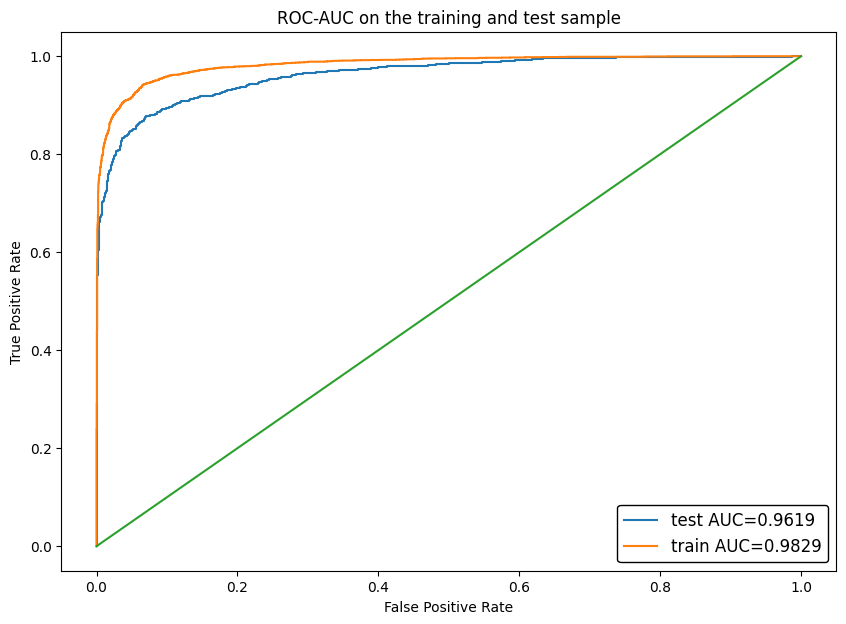

In [39]:
roc_auc_plot(y_test, pred_test, y_train, pred_train)

In [57]:
def precision_recall_plot(y_test, y_test_predicted, y_train, y_train_predicted):
    fig, ax = plt.subplots(figsize=(10, 7))

    test_display = PrecisionRecallDisplay.from_predictions(
        y_test, y_test_predicted, ax=ax
    )

    train_display = PrecisionRecallDisplay.from_predictions(
        y_train, y_train_predicted, ax=ax
    )
    ax.set_title('Precision and Recall for the test and train sample')
    plt.show()

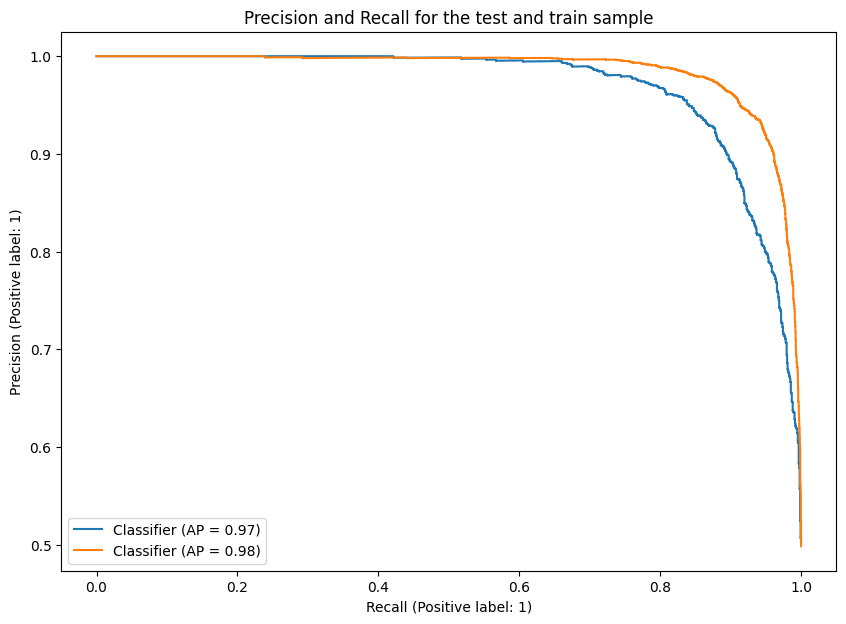

In [58]:
precision_recall_plot(y_test, pred_test, y_train, pred_train)

In [59]:
from sklearn.metrics import classification_report

In [63]:
pred_class = [(1 if pred[0] > 0.5 else 0) for pred in pred_test]
pred_class

[0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,


In [65]:
print(classification_report(y_test, pred_class))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1496
           1       0.89      0.90      0.90      1518

    accuracy                           0.90      3014
   macro avg       0.90      0.90      0.90      3014
weighted avg       0.90      0.90      0.90      3014

